# **Auxillary Code**
### *Complementary analyses to the main (MLEM reconstructor) file*

Elapsed time Image Loading: 1.569636344909668 seconds


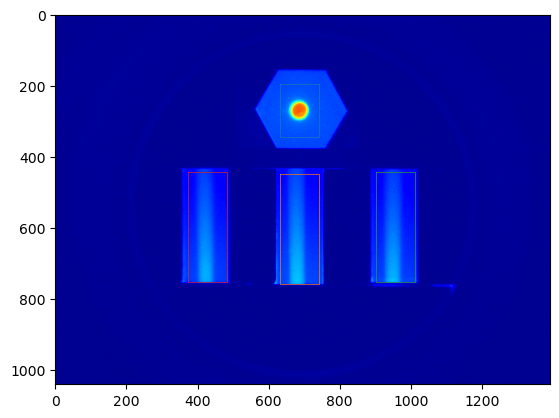

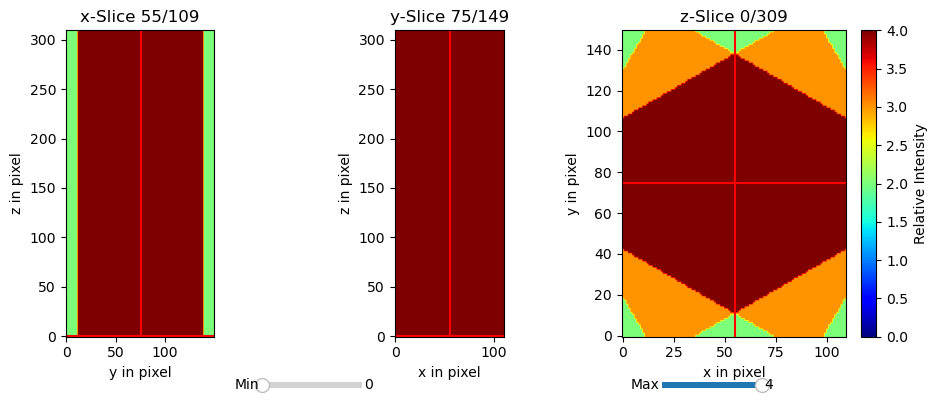

Elapsed time Correction Matrix: 3.35221004486084 seconds


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


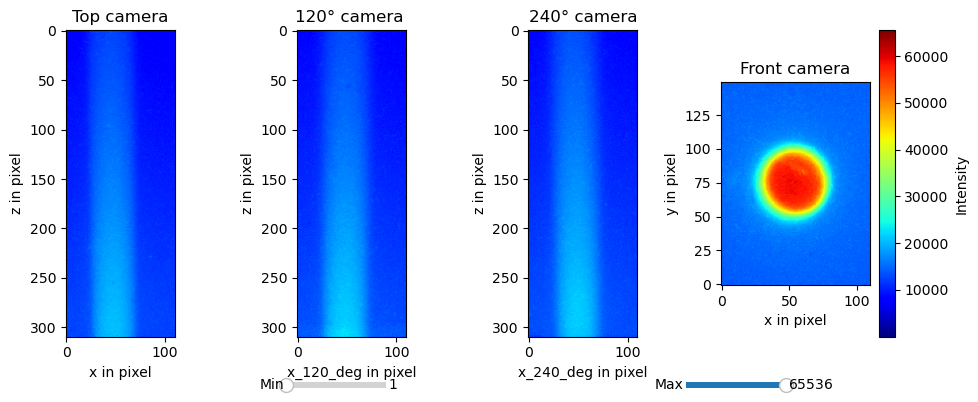

Elapsed time Camera Picture Viewer: 4.143693685531616 seconds
Iteration  1  done!
Iteration  2  done!
Iteration  3  done!
Iteration  4  done!
Quotient front:  [108.239990234375, 0.9346038699150085, 0.8489667177200317, 0.8153102993965149]
Quotient top:  [92.76377868652344, 0.9706591367721558, 0.951985239982605, 0.9438748359680176]
Quotient 120:  [116.13089752197266, 1.1895208358764648, 1.1542633771896362, 1.1389834880828857]
Quotient 240:  [118.16590118408203, 1.2112109661102295, 1.1757441759109497, 1.1602933406829834]


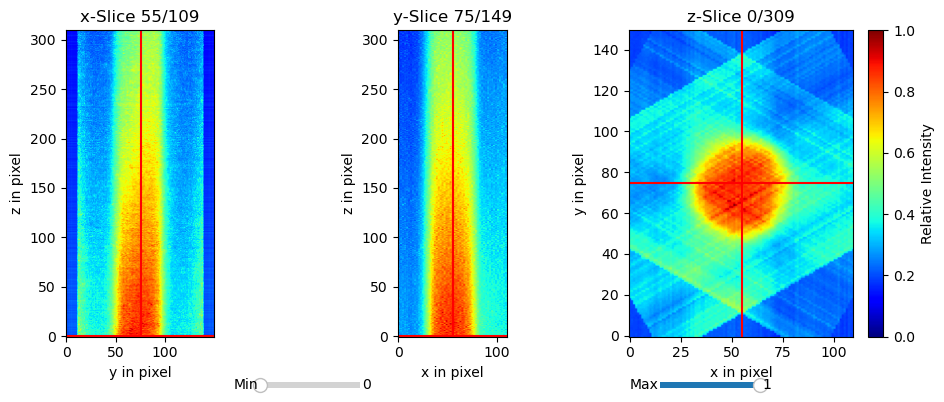

Elapsed time Reconstruction: 7.089650869369507 seconds


In [1]:
with open("main.py") as file:
    exec(file.read())

## **Objects available**
* Correction Matrix (310 x 150 x 11)
* path_pic (front, top, 120, 240)
* rec_light_dist -- tensor (310 x 150 x 11)

## Error Calculation

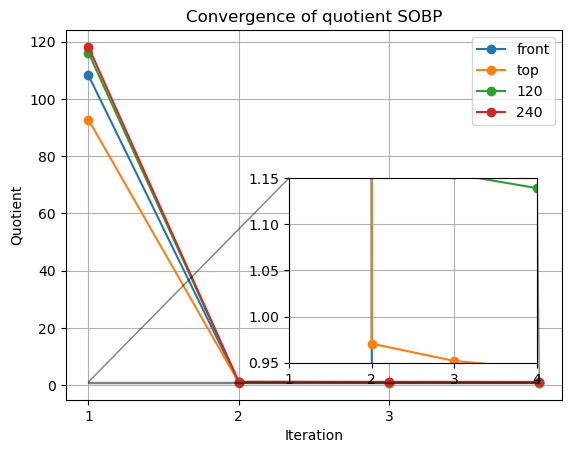

In [2]:
rec_light_dist = rec_light_dist.cpu().numpy()
dist_3D = np.sum(rec_light_dist, axis=(1, 2))
dist_3D_mask = np.zeros(np.shape(rec_light_dist))


def calculate_center_mean_per_slice(arr, radius):
    center = np.array(arr.shape) // 2
    # Initialize an array to store the mean values per slice
    mean_values_per_slice = np.zeros(arr.shape[0])
    mean_std_per_slice = np.zeros(arr.shape[0])

    for i in range(arr.shape[0]):
        # Create a meshgrid of indices for the current slice
        y, x = np.ogrid[: arr.shape[1], : arr.shape[2]]

        # Calculate the distance of each point from the center
        distance = np.sqrt((x - center[2]) ** 2 + (y - center[1]) ** 2)

        # Create a mask for points within the specified radius
        mask = distance <= radius

        # Extract values within the circular region for each slice
        circular_region = arr[i, mask]

        # Calculate the mean and standard deviation of the circular region for this slice
        mean_values_per_slice[i] = np.mean(circular_region)
        # mean_std_per_slice[i] = np.std(circular_region)/np.sqrt(len(circular_region))
        mean_std_per_slice[i] = np.std(circular_region)
    return mean_values_per_slice, mean_std_per_slice


mean_array, std = calculate_center_mean_per_slice(
    rec_light_dist, int((ROI_diam / s) / 2)
)
# reconstruction Error

q_front = np.array(reconstructor.quotient_front_ar)
q_top = np.array(reconstructor.quotient_top_ar)
q_120 = np.array(reconstructor.quotient_120_ar)
q_240 = np.array(reconstructor.quotient_240_ar)

q_err_rel = abs(((q_front[-1] + q_top[-1] + q_120[-1] + q_240[-1]) / 4) - 1)
q_err = np.zeros((deltaz))
for i in range(0, len(mean_array)):
    q_err[i] = mean_array[i] * q_err_rel
# calculate together with std

err_abs = np.zeros((deltaz))
for i in range(0, len(mean_array)):
    err_abs[i] = np.sqrt((q_err[i] ** 2) + (std[i] ** 2))

# Plot Error
major_ticks = np.arange(1, 4, 1)
ite = np.arange(1, len(q_front) + 1)
fig, ax = plt.subplots()
ax.plot(ite, q_front, marker="o", label="front")
ax.plot(ite, q_top, marker="o", label="top")
ax.plot(ite, q_120, marker="o", label="120")
ax.plot(ite, q_240, marker="o", label="240")
axins = ax.inset_axes([0.45, 0.1, 0.5, 0.5])
x1, x2, y1, y2 = 1, 4, 0.95, 1.15
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.plot(ite, q_front, marker="o", label="front")
axins.plot(ite, q_top, marker="o", label="top")
axins.plot(ite, q_120, marker="o", label="120")
axins.plot(ite, q_240, marker="o", label="240")
axins.grid(True)
ax.indicate_inset_zoom(axins, edgecolor="black")
ax.set_xticks(major_ticks)
ax.set_title("Convergence of quotient SOBP")
ax.set_xlabel("Iteration")
ax.set_ylabel("Quotient")
ax.legend()
ax.grid(True)

plt.show()

## Plotting Depth Dose Distribution

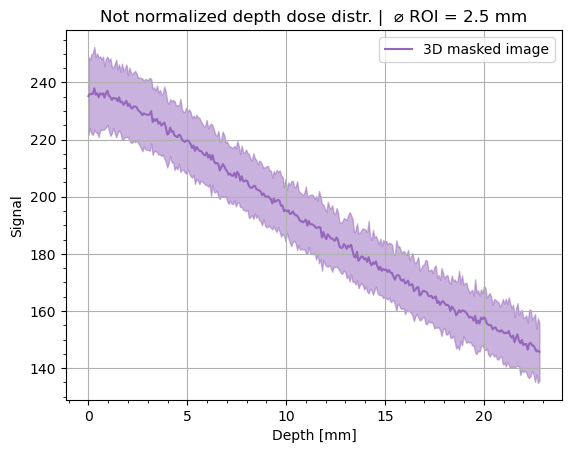

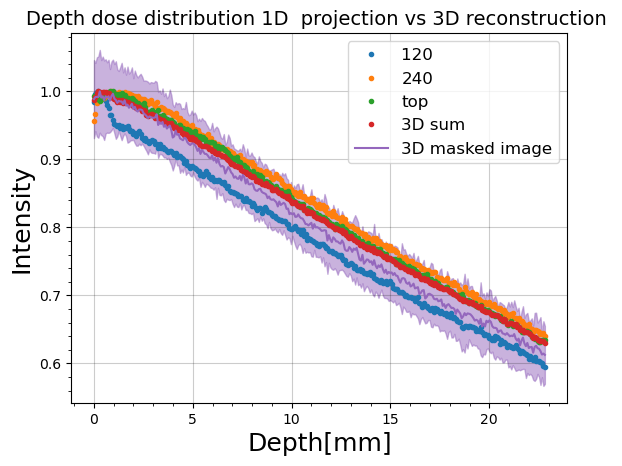

In [3]:
save_directory_notnormalized = "../pictures/online/output/" + picture_name[:-4] + "/" + "notnormalized/"
isExist = os.path.exists(save_directory_notnormalized)
if not isExist:
    # Create a new directory because it does not exist
   os.makedirs(save_directory_notnormalized)

# save_directory='pictures/spatialresolution/'
######################## saving 1D Data #######################################
np.save(save_directory_notnormalized + "notnormalizedmean_array" + picture_name[:-4], mean_array)
np.save(save_directory_notnormalized + "notnormalizederr" + picture_name[:-4], err_abs)
np.save(save_directory_notnormalized + "notnormalizedmean_array_notmasked" + picture_name[:-4], dist_3D)

#######################  1D Plotting ##########################################
#%%
fig, ax = plt.subplots()

ax.plot(
    np.arange(0, len(mean_array), 1) * s,
    mean_array ,
    color="tab:purple",
    label="3D masked image",
)
ax.fill_between(
    np.arange(0, len(mean_array), 1) * s,
    mean_array  + (err_abs),
    mean_array  - (err_abs),
    color='tab:purple',
    alpha = 0.5,
) 
ax.set_title('Not normalized depth dose distr. |  ⌀ ROI = {} mm'.format(ROI_diam))
ax.set_xlabel('Depth [mm]')
ax.set_ylabel('Signal')
ax.legend()
ax.grid(True)
plt.minorticks_on()
plt.show()


#%%
cam_pic_front = cam_pic_front.cpu().numpy()
cam_pic_top = cam_pic_top.cpu().numpy()
cam_pic_120 = cam_pic_120.cpu().numpy()
cam_pic_240 = cam_pic_240.cpu().numpy()
######### normalized ##########################
dist_1D_120 = np.flip(np.sum(cam_pic_120, axis=(1)))

np.save(save_directory_notnormalized + "dist_1D_120_" + picture_name[:-4], dist_1D_120)
plt.plot(
    np.arange(0, deltaz, 1) * s, dist_1D_120 / np.max(dist_1D_120), ".", label="120 "
)
dist_1D_240 = np.flip(np.sum(cam_pic_240, axis=(1)))
np.save(save_directory_notnormalized + "dist_1D_240_" + picture_name[:-4], dist_1D_240)
plt.plot(
    np.arange(0, deltaz, 1) * s, dist_1D_240 / np.max(dist_1D_240), ".", label="240"
)
dist_1D_top = np.flip(np.sum(cam_pic_top, axis=(1)))
np.save(save_directory_notnormalized + "dist_1D_top_" + picture_name[:-4], dist_1D_top)
plt.plot(
    (np.arange(0, deltaz, 1) * s), dist_1D_top / np.max(dist_1D_top), ".", label="top"
)

plt.plot(
    np.arange(0, deltaz, 1) * s,
    dist_3D / np.max(dist_3D),
    ".",
    label="3D sum",
)

TOF = [0, 0, 0]
mean_array = np.append(mean_array, TOF)
mean_array = mean_array[:-3]  # eliminate the TOF data
plt.plot(
    np.arange(0, len(mean_array), 1) * s,
    mean_array / np.max(mean_array),
    color="tab:purple",
    label="3D masked image",
)
plt.fill_between(
    np.arange(0, len(mean_array), 1) * s,
    mean_array / np.max(mean_array) + (err_abs/ np.max(mean_array)),
    mean_array / np.max(mean_array) - (err_abs/ np.max(mean_array)),
    color='tab:purple',
    alpha = 0.5,
) 

plt.title(
    "Depth dose distribution 1D  projection vs 3D reconstruction ",
    fontdict=None,
    loc="center",
    fontsize=14,
)
plt.legend(fontsize="large")
plt.xlabel("Depth[mm]", fontsize=18)
plt.ylabel("Intensity", fontsize=18)

plt.grid(which="major", color="k", linestyle="-", alpha=0.2)
#plt.grid(which="minor", color="k", linestyle="-", alpha=0.2)
plt.minorticks_on()
# plt.show()

## Lateral and Vertical Profiles

In [4]:
def Lateral_profile(image_array, thick, pos):
    image_array = np.flip(image_array, axis=0)
    # Get the dimensions of the image
    height, width = image_array.shape
    # Determine the middle row of the image
    middle_row = height // 2 + pos
    # Initialize an empty list to store the mean intensity values
    mean_intensity_values = []

    # Calculate the mean intensity over a 10-pixel thickness in the y-direction for every x-value
    for i in range(width):
        mean_intensity = np.mean(image_array[middle_row - int(thick/2): middle_row + int(thick/2), i])
        mean_intensity_values.append(mean_intensity)

    # Plot the lateral intensity profile
    plt.figure(figsize=(10, 5))
    #plt.plot(range(width), mean_intensity_values, label='Intensity Profile')
    plt.title('Lateral Intensity Profile position')
    plt.xlabel('Pixel Position')
    plt.ylabel('Pixel Position')
    plt.imshow(image_array, cmap='jet')
    plt.axhline(y=middle_row - int(thick/2), color='r', linestyle='-', label='Profile Location')
    plt.axhline(y=middle_row + int(thick/2), color='r', linestyle='-')
    plt.legend()
    plt.show()  
    
    return mean_intensity_values, width

def Vertical_profile(image_array, thick, pos):
    image_array = np.flip(image_array, axis=0)
    # Get the dimensions of the image
    height, width = image_array.shape
    # Determine the middle column of the image
    middle_col = width // 2 + pos
    # Initialize an empty list to store the mean intensity values
    mean_intensity_values = []

    # Calculate the mean intensity over a 10-pixel thickness in the x-direction for every y-value
    for i in range(height):
        mean_intensity = np.mean(image_array[i, middle_col - int(thick/2): middle_col + int(thick/2)])
        mean_intensity_values.append(mean_intensity)

    # Plot the vertical intensity profile
    plt.figure(figsize=(10, 5))
    plt.imshow(image_array, cmap='jet')
    plt.title('Vertical Intensity Profile')
    plt.xlabel('Pixel Position')
    plt.ylabel('Pixel Position')
    plt.axvline(x=middle_col - int(thick/2), color='r', linestyle='-', label='Profile Location')
    plt.axvline(x=middle_col + int(thick/2), color='r', linestyle='-')
    plt.legend()
    plt.show()  
    
    return mean_intensity_values, height

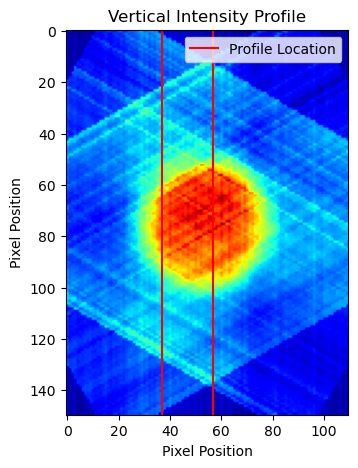

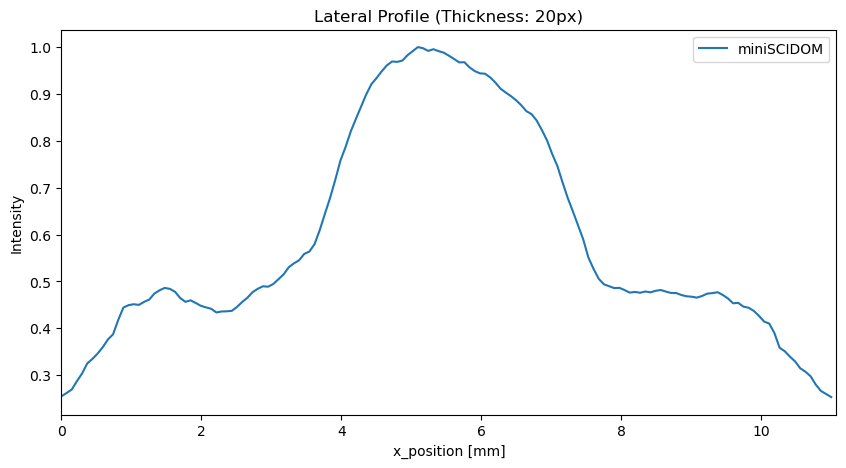

In [5]:
thickness = 20
position_adj = -8
profile_values, width = Vertical_profile(rec_light_dist[145,:,:],thickness,position_adj)
#profile_values = profile_values[30:]
#profile_values = np.flip(profile_values)
# Read data from CSV file
#df = pd.read_csv("//filecns/projects/HPLexp/ions/projects/Ionenbeschleunigung/2023/miniSCIDOM II/X-Raytube data/2024-03-12 X-ray Tube RCF/ValuesRCF8.csv")
#x_csv = np.array(df['Distance_(inches)'].values*25.4)+0.45
#y_csv = np.array(df['Gray_Value'].values)

# Plot the lateral intensity profile
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, len(profile_values), 1) * s, profile_values/np.max(profile_values), label='miniSCIDOM')
#plt.plot(x_csv, y_csv/np.max(y_csv), linestyle='--', label = "RCF")
plt.title(f'Lateral Profile (Thickness: {thickness}px)')
plt.xlabel('x_position [mm]')
plt.ylabel('Intensity')
plt.xlim(0,len(profile_values)*s)
plt.legend()
plt.show()

## Save ROI data

In [6]:
#%%##########Save ROI data ##########################
with open(save_directory+"ROI_Data.txt", 'w') as file:
    file.write(f'shape_front = {shape_front}\n')
    file.write(f'shape_side = {shape_side}\n')
    file.write(f'deltaz = {deltaz}\n')
    file.write(f'rot_angle = {rot_angle}\n')
    file.write(f'x_0 = {x_0}\n')
    file.write(f'y_0 = {y_0}\n')
    file.write(f'y1_front = {y1_front}\n')
    file.write(f'y2_front = {y2_front}\n')
    file.write(f'x1_front = {x1_front}\n')
    file.write(f'x2_front = {x2_front}\n')
    file.write(f'y1_top = {y1_top}\n')
    file.write(f'y2_top = {y2_top}\n')
    file.write(f'x1_top = {x1_top}\n')
    file.write(f'x2_top = {x2_top}\n')
    file.write(f'y1_120 = {y1_120}\n')
    file.write(f'y2_120 = {y2_120}\n')
    file.write(f'x1_120 = {x1_120}\n')
    file.write(f'x2_120 = {x2_120}\n')
    file.write(f'y1_240 = {y1_240}\n')
    file.write(f'y2_240 = {y2_240}\n')
    file.write(f'x1_240 = {x1_240}\n')
    file.write(f'x2_240 = {x2_240}\n')
    file.write(f'shift_image_front = {shift_image_front}\n')
    file.write(f'shift_image_top = {shift_image_top}\n')
    file.write(f'shift_image_120 = {shift_image_120}\n')
    file.write(f'shift_image_240 = {shift_image_240}\n')
    file.write('#######################################\n')
    file.write(f's = {s} #Resolution (mm/pixel) depends on camera\n')
    file.write(f'ROI_diam = {ROI_diam}')

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Elapsed time: {elapsed_time} seconds")

### unused - LET Correction

In [12]:
# import pandas as pd
# from letcorrection3D import letcorrection
# from getprofile import Get_profile

In [14]:
# header = pd.read_csv(outputfile_topas, nrows=7)
# df = pd.read_csv(outputfile_topas, comment="#", header=None)
# topas_datamatrix = np.array(df)  # convert dataframe df to array
# letprofile = Get_profile(topas_datamatrix, 149, 1)
# zletprofile = letprofile.zmeanprofile
# zletprofile = zletprofile[::-1]

# letcorrection = letcorrection(mean_array, zletprofile, s)
# lightcorrection_value = letcorrection.lightcorrection

# matrix_3D_corrected = np.zeros(
#     np.shape(rec_light_dist)
# )  # ((deltaz, 186, 152) z is the first =deltaz

# for i in range(np.shape(rec_light_dist)[0]):  # from 0 to 158
#     matrix_3D_corrected[i, :, :] = np.divide(
#         rec_light_dist[i, :, :],
#         lightcorrection_value[i],
#         out=np.zeros_like(rec_light_dist[i, :, :]),
#         where=lightcorrection_value[i] != 0,
#     )

# Tomograpic_viewer(
#     matrix_3D_corrected / matrix_3D_corrected.max(), False, 1
# )  # here you can enable the logaritmic scale
# # matrix_3D_corrected_calib=matrix_3D_corrected*calib_value
# # print(matrix_3D_corrected_calib.max())
# # Tomograpic_viewer(matrix_3D_corrected_calib,False,0.834) # here you can enable the logarit

### unused - calculate rings mean + rings_error

In [ ]:
# def calculate_rings_mean_std_per_slice(arr, radius, num_rings):
#     center = np.array(arr.shape) // 2
#     mean_values_per_slice = np.zeros((arr.shape[0], num_rings))
#     mean_std_per_slice = np.zeros((arr.shape[0], num_rings))

#     for i in range(arr.shape[0]):
#         y, x = np.ogrid[:arr.shape[1], :arr.shape[2]]
#         distance = np.sqrt((x - center[2]) ** 2 + (y - center[1]) ** 2)
        
#         # Create a mask for points within the specified radius
#         mask = distance <= radius
        
#         # Divide the circular region into rings
#         ring_width = radius / num_rings
#         ring_masks = [(distance >= j * ring_width) & (distance <= (j + 1) * ring_width) for j in range(num_rings)]
        
#         # Calculate mean and standard deviation for each ring
#         for j, ring_mask in enumerate(ring_masks):
#             ring_values = arr[i, ring_mask]
#             mean_values_per_slice[i, j] = np.mean(ring_values)
#             mean_std_per_slice[i, j] = np.std(ring_values)

#     return mean_values_per_slice, mean_std_per_slice, distance, ring_masks

#%% =============================================================================
# def calculate_center_mean_per_slice(arr, diameter):
#     if diameter % 2 == 0:
#         raise ValueError("The diameter should be an odd number.")
# 
#     center = np.array(arr.shape) // 2
#     half_diameter = diameter // 2
# 
#     # Calculate the starting and ending indices of the center region
#     start_idx = center - half_diameter
#     end_idx = center + half_diameter + 1
# 
#     # Initialize an array to store the mean values per slice
#     mean_values_per_slice = np.zeros(arr.shape[0])
#     mean_std_per_slice = np.zeros(arr.shape[0])
# 
#     for i in range(arr.shape[0]):
#         # Extract the center region for each slice
#         center_region = arr[i, start_idx[1]:end_idx[1], start_idx[2]:end_idx[2]]
#         # Calculate the mean of the center region for this slice
#         mean_values_per_slice[i] = np.mean(center_region)
#         mean_std_per_slice[i] = np.std(center_region)
#             
# 
#     return mean_values_per_slice, mean_std_per_slice
# %%=============================================================================

# mean_array, std = calculate_center_mean_per_slice(rec_light_dist, int((ROI_diam/s)/2))

# if ring_error == True:
#     mean_ring_array, std_ring, distance, ring_masks = calculate_rings_mean_std_per_slice(rec_light_dist, int((ROI_diam/s)/2), num_rings)
#     std = np.mean((std_ring/mean_ring_array), axis = 1) #calculate the STD for selected amount of Rings
#     std = std * mean_array
#     # ########Show selected Rings on a slice
#     plt.figure(figsize=(10, 6))
#     plt.imshow(rec_light_dist[50,:,:], cmap='jet')
#     for j, ring_mask in enumerate(ring_masks):
#         ring_mask_outline = np.logical_xor(ring_mask, np.roll(ring_mask, 1, axis=0))
#         ring_mask_outline = np.logical_or(ring_mask_outline, np.roll(ring_mask, 1, axis=1))
#         plt.contour(ring_mask_outline, levels=[0.5], colors=[f'C{j}'], linewidths=2)
#     plt.title('Slice Nr. 50 with Rings')
#     plt.show()

### unused - mean value per slice + old masks

In [ ]:
# def calculate_center_sum_per_slice(arr, radius):
#     center = np.array(arr.shape) // 2
#     # Initialize an array to store the mean values per slice
#     mean_values_per_slice = np.zeros(arr.shape[0])

#     for i in range(arr.shape[0]):
#         # Create a meshgrid of indices for the current slice
#         y, x = np.ogrid[:arr.shape[1], :arr.shape[2]]
        
#         # Calculate the distance of each point from the center
#         distance = np.sqrt((x - center[2]) ** 2 + (y - center[1]) ** 2)
        
#         # Create a mask for points within the specified radius
#         mask = distance <= radius
        
#         # Extract values within the circular region for each slice
#         circular_region = arr[i, mask]
        
#         # Calculate the mean and standard deviation of the circular region for this slice
#         mean_values_per_slice[i] = np.sum(circular_region)

#     return mean_values_per_slice


# sum_3D = calculate_center_sum_per_slice(rec_light_dist, int((ROI_diam_sum/s)/2))


# #%% Old Mask from Angela ===================================================
# def create_circular_mask(h, w, center=None, radius=None):

#     if center is None:  # use the middle of the image
#         center = (int(w / 2), int(h / 2))
#     if radius is None:  # use the smallest distance between the center and image walls
#         radius = min(center[0], center[1], w - center[0], h - center[1])

#     YY, XX = np.ogrid[:h, :w]
#     dist_from_center = np.sqrt((XX - center[0]) ** 2 + (YY - center[1]) ** 2)

#     mask = dist_from_center <= radius
#     return mask

# #mean_array = np.zeros((deltaz))
# std_old = np.zeros((deltaz))
# err_old = np.zeros((deltaz))
# for index,element in enumerate(mean_array):
#     img = rec_light_dist[index, :, :]
#     h, w = img.shape[:2]

#     innerradius = int((2.3/s)/2) # int((5/s)/2)  # 34 40 #5mm diamter inner circle
#     # innerradius=55 #7mm
#     mask = create_circular_mask(
#         h, w, radius=innerradius
#     )  # create a boolean circle mask
#     dist_3D_mask[index, mask] = img[mask]
#     element = np.mean(img[mask], axis=0) #element=mean_array[index]
#     std_old[index] = np.std(img[mask], axis=0)
#     err_old[index] = std_old[index] / np.sqrt(len(img[mask]))

### unused - plot preliminary Dose

In [ ]:
#%% Plot Preliminary Dose ###############

# dose_cal_fac = 0.0000026 #Extracted from the shots from 25.09.2020
#                          #Exposure time = 100ms, basler acA1300-60gm
# fig2, ax1 = plt.subplots()
# fig2.set_size_inches(5, 3.5)
# fig2.suptitle('Preliminary  Depth dose distribution | ⌀ ROI = {} mm'.format(ROI_diam_sum))
# ax1.plot(
#     np.arange(0, len(sum_3D), 1) * s,
#     sum_3D*dose_cal_fac ,
#     color="tab:blue",
#     label="3D masked image",
# )
# # ax1.fill_between(
# #     np.arange(0, len(sum_3D), 1) * s,
# #     sum_3D*dose_cal_fac  + (sum_3D*0.06*dose_cal_fac),
# #     sum_3D*dose_cal_fac  - (sum_3D*0.06*dose_cal_fac),
# #     color='tab:purple',
# #     alpha = 0.5,
# # )
# ax1.set_title("")
# ax1.set(xlabel = "Depth [mm]", ylabel = "Dose [Gy]")
# ax1.grid(True)
# #ax1.set_aspect(2) 

